In [2]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [134]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 10

means = np.random.randint(low=10, high=100, size=n_genotypes)
means = means * (means > 0)  # negative activities are not captured
sds = np.random.random(size=n_genotypes) * 30
num_measurements = np.random.randint(low=2, high=5, size=n_genotypes)

# Create simulated data.
data = []
indices = []

for i in range(n_genotypes):
    n = num_measurements[i]
    mean = means[i]
    sd = sds[i]
    
    measurements = np.random.normal(loc=mean, scale=sd, size=n)
    # print(measurements)
    measurements = measurements * (measurements > 0)
    # print(measurements)
    
    data.extend(measurements.tolist())
    indices.extend([i] * n)

# Add baseline measurements (bl_measures)
n_bl_measures = 2
bl_measures = np.random.normal(loc=1.0, scale=0.1, size=n_bl_measures)
bl_measures = bl_measures * (bl_measures > 0)
data.extend(bl_measures)
indices.extend([n_genotypes] * n_bl_measures)
num_measurements = np.append(num_measurements, n_bl_measures)
means = np.append(means, bl_measures.mean())
sds = np.append(sds, bl_measures.std())

# Add pos_ctrl measurements (pc_measures)
n_pc_measures = 10
pc_measures = np.random.normal(loc=20.0, scale=2, size=n_pc_measures)
pc_measures = pc_measures * (pc_measures > 0)
data.extend(pc_measures)
indices.extend([n_genotypes + 1] * n_pc_measures)
num_measurements = np.append(num_measurements, n_pc_measures)
means = np.append(means, pc_measures.mean())
sds = np.append(sds, pc_measures.std())

# convert indices to a numpy array
indices = np.array(indices)

In [135]:
indices

array([ 0,  0,  1,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  4,  5,  5,
        5,  5,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9, 10, 10, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11])

In [136]:
means

array([ 41.        ,  49.        ,  37.        ,  66.        ,
        22.        ,  14.        ,  26.        ,  42.        ,
        95.        ,  66.        ,   1.00062285,  19.95569333])

In [137]:
sds

array([  2.04753993e+01,   2.65326722e+01,   4.18316164e+00,
         7.19949913e+00,   2.10640537e+01,   1.88810350e+00,
         2.07455017e+01,   4.90655921e+00,   1.10134903e+01,
         3.92708013e+00,   2.83894483e-04,   2.27931077e+00])

In [138]:
num_measurements

array([ 2,  4,  3,  2,  4,  4,  2,  4,  4,  2,  2, 10])

In [139]:
len(data), len(indices)

(43, 43)

In [140]:
np.array(data)

array([  56.23667473,   57.34570472,   45.42150563,   51.68184925,
         41.91912183,   65.8047164 ,   38.9703447 ,   38.29796152,
         40.3107049 ,   58.05969162,   64.34954412,   31.54733311,
         -0.        ,   55.95341011,   27.66828077,   13.90869318,
         13.18096991,   12.81825272,   12.78887304,   37.94065505,
         36.33104475,   47.45967043,   41.88683516,   37.80583932,
         44.50336678,   80.39648691,   88.48799218,   92.45103754,
        107.10211669,   66.20634715,   62.57692166,    1.00090674,
          1.00033895,   24.22187401,   23.39824807,   18.49849954,
         18.71503843,   17.70688068,   18.01624194,   18.6293841 ,
         18.2254999 ,   20.03050781,   22.11475883])

In [141]:
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.63921083881159535

In [193]:
with pm.Model() as model:
    # Hyperpriors
    upper = pm.Exponential('upper', lam=0.05)
    lower = pm.Exponential('lower', lam=1)

    # "fold", which is the estimated fold change.
    fold = pm.Uniform('fold', lower=lower, upper=upper, shape=n_genotypes+2)
    
    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    sigma = pm.Gamma('sigma', alpha=1, beta=1000, shape=n_genotypes+2)
    
    # Model prediction
    mu = fold[indices]
    sig = sigma[indices]
    
    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data)
    
    # Compute Z-factors relative to positive ctrl.
    z_factor = pm.Deterministic('z_factor', 1 - (3 * sigma[:-1] + 3 * sigma[-1]) / np.abs(fold[:-1] - fold[-1]))
    
    # Compute Z-prime factor between negative and positive control.
    zp_factor = pm.Deterministic('zp_factor', 1 - (3 * sigma[-2] + 3 * sigma[-1]) / np.abs(fold[-2] - fold[-1]))
    
    # Compute fold changes
    fold_changes = pm.Deterministic('fold_changes', fold[:-2] / fold[-1])

INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-16.0.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir/lock


Applied log-transform to upper and added transformed upper_log_ to model.
Applied log-transform to lower and added transformed lower_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [194]:
%%time
with model:
    if n_genotypes <= 10:
        n_steps = 150000
    elif n_genotypes > 10:
        n_steps = 200000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -254861384211.45
Iteration 15000 [10%]: Average ELBO = -inf
Iteration 30000 [20%]: Average ELBO = -617139.36
Iteration 45000 [30%]: Average ELBO = -6537.16
Iteration 60000 [40%]: Average ELBO = -6330.14
Iteration 75000 [50%]: Average ELBO = -6326.36
Iteration 90000 [60%]: Average ELBO = -6325.48
Iteration 105000 [70%]: Average ELBO = -6325.07
Iteration 120000 [80%]: Average ELBO = -6325.08
Iteration 135000 [90%]: Average ELBO = -6324.99
Finished [100%]: Average ELBO = -6324.98
CPU times: user 27.1 s, sys: 342 ms, total: 27.4 s
Wall time: 30.9 s


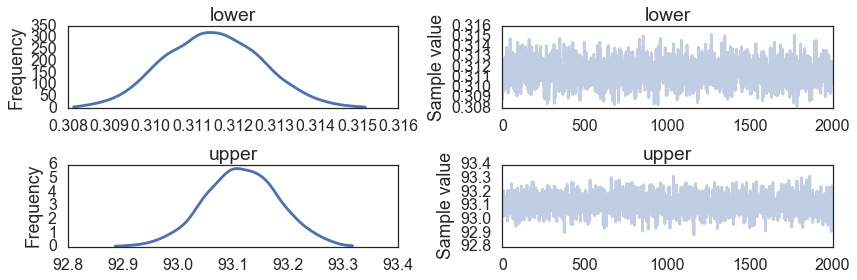

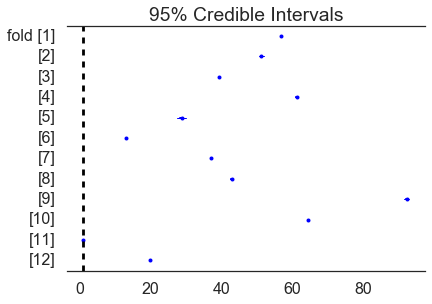

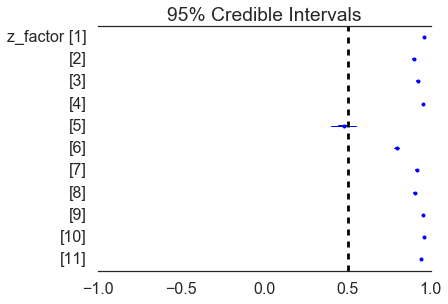

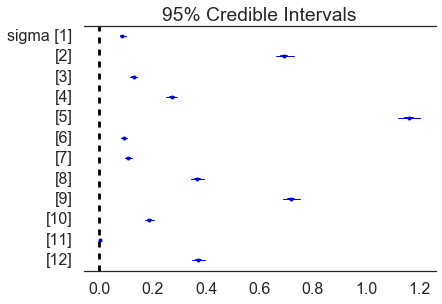

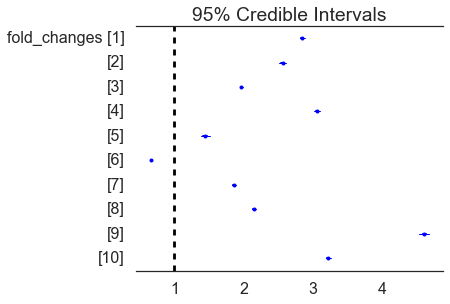

In [196]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.traceplot(trace, varnames=['lower', 'upper'])
    
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['z_factor'], xrange=(-1, 1), vline=0.5)
    
    fig = plt.figure()
    pm.forestplot(trace, varnames=['sigma'])
    
    plt.figure()
    pm.forestplot(trace, varnames=['fold_changes'], vline=1)

In [190]:
# plt.figure()
# pm.forestplot(trace, varnames=['fold_lam'])
# plt.figure()
# pm.traceplot(trace, varnames=['fold_lam'])

In [191]:
if n_genotypes <= 15:
    pm.summary(trace)


upper:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  93.114           0.052            0.001            [93.018, 93.220]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  93.015         93.076         93.114         93.150         93.218


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  56.809           0.069            0.001            [56.681, 56.942]
  51.234           0.360            0.009            [50.530, 51.921]
  39.253           0.083            0.002            [39.099, 39.411]
  61.183           0.211            0.005            [60.759, 61.591]
  28.794           0.646            0.015            [27.570, 30.039]
  13.178           0.050            0.001        

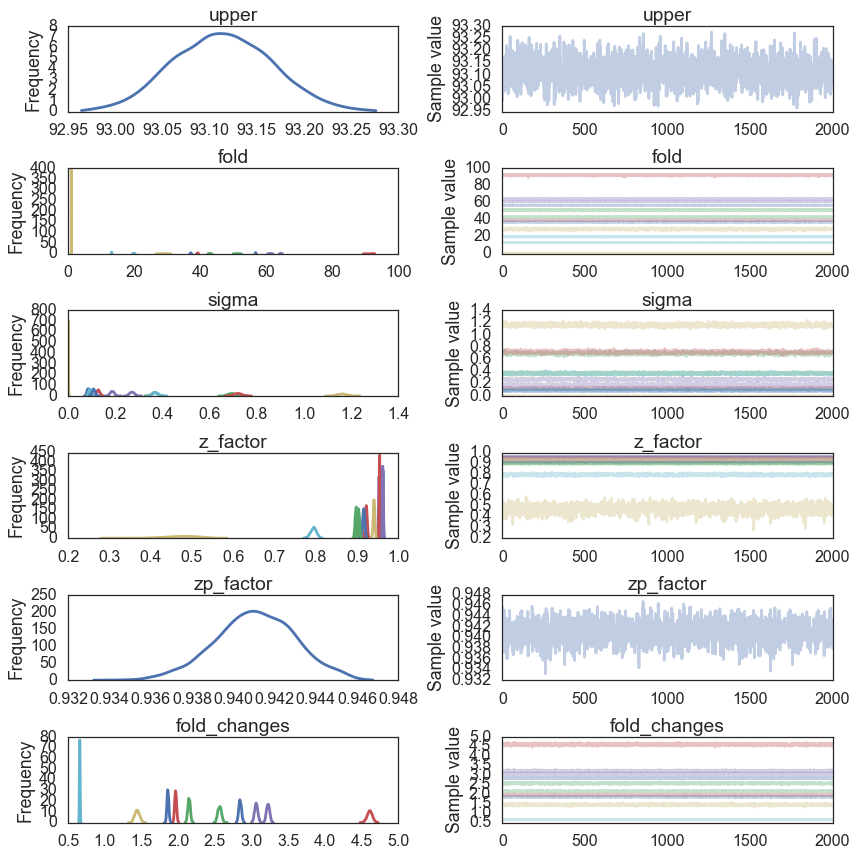

In [192]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [172]:
num_measurements

array([ 2,  4,  3,  2,  4,  4,  2,  4,  4,  2,  2, 10])

In [173]:
trace['fold'].mean(axis=0) - means

array([  1.58165715e+01,   2.30579955e+00,   2.30795504e+00,
        -4.77787379e+00,   6.89064444e+00,  -8.12688757e-01,
         1.11668028e+01,   9.40879419e-01,  -2.93321171e+00,
        -1.54719255e+00,   1.99944734e-03,   3.67258715e-02])

In [174]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,2.0,15.816571
1,4.0,2.305800
2,3.0,2.307955
3,2.0,-4.777874
4,4.0,6.890644


In [175]:
if n_genotypes >= 500:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('var(error)')

In [176]:
(trace['fold'].mean(axis=0) - means).mean()

2.4497009338236575

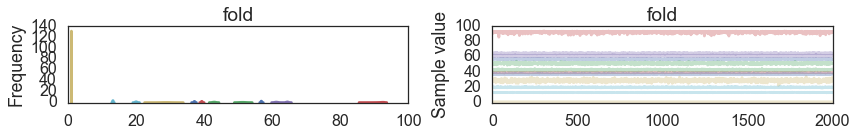

In [177]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128020d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x128e7a518>]], dtype=object)

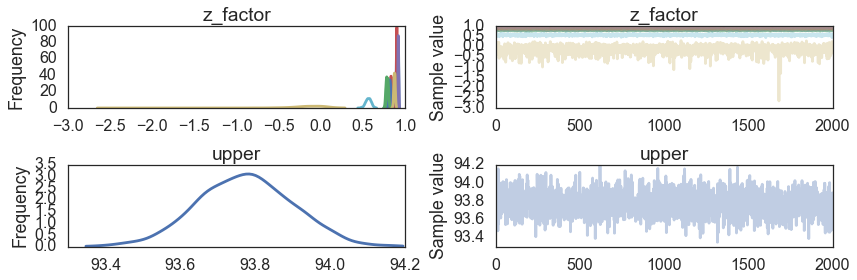

In [178]:
pm.traceplot(trace, varnames=['z_factor', 'upper'])

# Compare modelled to actual

In [179]:
trace['fold'].mean(axis=0)

array([ 56.81657146,  51.30579955,  39.30795504,  61.22212621,
        28.89064444,  13.18731124,  37.16680278,  42.94087942,
        92.06678829,  64.45280745,   1.0026223 ,  19.9924192 ])

In [180]:
trace['fold'].mean(axis=0).shape

(12,)

In [181]:
np.arange(1, n_genotypes+3).shape

(12,)

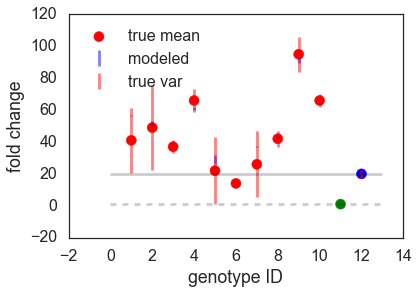

In [182]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

just for checking the above plot...


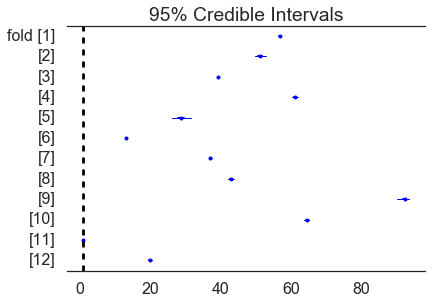

In [183]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

How does Z-factor vary as a function of variance for a fixed set of replicate measurements?

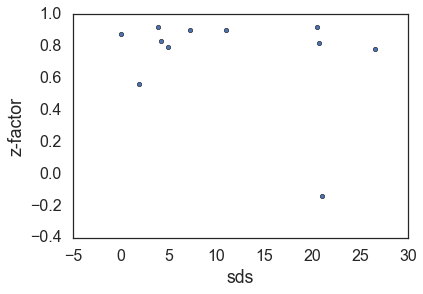

In [184]:
df = pd.DataFrame()
df['z-factor'] = trace['z_factor'].mean(axis=0)
df['num_measurements'] = num_measurements[:-1]
df['sds'] = sds[:-1]

df.plot(kind='scatter', x='sds', y='z-factor')

In [185]:
num_measurements.shape

(12,)

In [186]:
trace['z_factor'].shape

(2000, 11)